## Imports

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
import optuna
import time
import lightgbm as lgb
import os
from sklearn.metrics import root_mean_squared_error
from scipy.optimize import minimize as sp_minimize
from sklearn.preprocessing import StandardScaler
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

## Configs

In [34]:
train_path = '../data/train.csv'
test_path = '../data/test_for_participants.csv'
sample_path = '../data/sample_submission.csv'

# ── Dual Validation Date Boundaries ──────────────────────────────
# Val Set 1 (Physics): Autumn/Winter 2024 — cold, dark, windy grid
VAL_PHYSICS_START = '2024-09-01'
VAL_PHYSICS_END   = '2025-01-01'
# Val Set 2 (Recency): Summer 2025 — last 3 months before LB
VAL_RECENCY_START = '2025-06-01'

SEED = 42
N_TRIALS_LGB = 30
SAVED_LGB_PATH = '../models/lgb_final.txt'
ROUND_MULTIPLIER = 1.15

os.makedirs('../models', exist_ok=True)

# Set random seed for reproducibility
np.random.seed(SEED)

## Data loading

In [35]:
train_raw = pd.read_csv(train_path)
test_raw = pd.read_csv(test_path)
sample_sub = pd.read_csv(sample_path)

In [36]:
for df in [train_raw, test_raw]:
    df['delivery_start'] = pd.to_datetime(df['delivery_start'])
    df['delivery_end'] = pd.to_datetime(df['delivery_end'])

train_raw['is_test'] = 0
test_raw['is_test'] = 1
test_raw['target'] = np.nan

df = pd.concat([train_raw, test_raw], ignore_index=True)
df = df.sort_values(['market', 'delivery_start']).reset_index(drop=True)
df.head()

,id,target,market,global_horizontal_irradiance,diffuse_horizontal_irradiance,direct_normal_irradiance,cloud_cover_total,cloud_cover_low,cloud_cover_mid,cloud_cover_high,...,wind_speed_80m,wind_direction_80m,wind_gust_speed_10m,wind_speed_10m,solar_forecast,wind_forecast,load_forecast,delivery_start,delivery_end,is_test
0,0,-1.913,Market A,0.0,0.0,0.0,2.0,0.0,0.0,2.0,...,31.253719,245.501450,25.199999,15.077082,0.0,24050.1,38163.0100,2023-01-01 00:00:00,2023-01-01 01:00:00,0
1,5,-0.839,Market A,0.0,0.0,0.0,15.0,0.0,0.0,15.0,...,30.918108,242.241547,23.400000,14.186923,0.0,23886.3,37379.1898,2023-01-01 01:00:00,2023-01-01 02:00:00,0
2,10,-1.107,Market A,0.0,0.0,0.0,17.0,0.0,0.0,17.0,...,26.983196,224.999893,21.240000,12.413477,0.0,23366.5,36336.8303,2023-01-01 02:00:00,2023-01-01 03:00:00,0
3,15,0.035,Market A,0.0,0.0,0.0,16.0,0.0,0.0,16.0,...,22.218153,229.600174,16.199999,10.483357,0.0,22829.8,35337.7595,2023-01-01 03:00:00,2023-01-01 04:00:00,0
4,20,-0.829,Market A,0.0,0.0,0.0,10.0,0.0,0.0,10.0,...,27.210381,244.113022,18.359999,11.918120,0.0,22347.6,34474.3403,2023-01-01 04:00:00,2023-01-01 05:00:00,0


## Enhanced Feature Engineering - Ultra Advanced Version

In [37]:
# Basic time features
ds = df["delivery_start"]
df["hour"]         = ds.dt.hour
df["day_of_week"]  = ds.dt.dayofweek
df["day_of_month"] = ds.dt.day
df["month"]        = ds.dt.month
df["quarter"]      = ds.dt.quarter
df["day_of_year"]  = ds.dt.dayofyear
df["year"]         = ds.dt.year
df["is_weekend"]   = (ds.dt.dayofweek >= 5).astype(np.int8)
df["week_of_year"] = ds.dt.isocalendar().week.astype(int)

# Cyclical encoding for time features
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

# Market encoding
market_map = {f"Market {c}": i for i, c in enumerate("ABCDEF")}
df["market_id"] = df["market"].map(market_map).astype(np.int8)

# Advanced demand and supply features
df["residual_demand"] = df["load_forecast"] - df["solar_forecast"] - df["wind_forecast"]
df["supply_ratio"] = (df["solar_forecast"] + df["wind_forecast"]) / (df["load_forecast"] + 1)
df["renewable_ratio"] = (df["solar_forecast"] + df["wind_forecast"]) / (df["solar_forecast"] + df["wind_forecast"] + df["load_forecast"] + 1)
df["net_supply"] = df["solar_forecast"] + df["wind_forecast"]
df["demand_supply_balance"] = df["load_forecast"] / (df["solar_forecast"] + df["wind_forecast"] + 1)

# Tightness ratios
df["tightness_ratio"] = df["residual_demand"] / (df["load_forecast"] + 1)
df["tightness_x_month"] = df["tightness_ratio"] * df["month"]
df["tightness_x_hour"] = df["tightness_ratio"] * df["hour"]
df["tightness_x_dow"] = df["tightness_ratio"] * df["day_of_week"]

# Price sensitivity indicators
df["solar_wind_ratio"] = df["solar_forecast"] / (df["wind_forecast"] + 1)
df["wind_solar_ratio"] = df["wind_forecast"] / (df["solar_forecast"] + 1)

In [38]:
# ── Advanced Weather Physics Features ──────────────────────────────────────
# First, alias columns whose names differ between dataset and our code

if 'convective_available_potential_energy' in df.columns:
    df['cape'] = df['convective_available_potential_energy']
if 'precipitation_amount' in df.columns:
    df['precipitation'] = df['precipitation_amount']
if 'apparent_temperature_2m' in df.columns:
    df['apparent_temperature'] = df['apparent_temperature_2m']
if 'freezing_level_height' in df.columns:
    df['boundary_layer_height'] = df['freezing_level_height']

# Estimate missing columns from available physics
# Saturation vapour pressure (Tetens formula)
es = 6.112 * np.exp((17.67 * df['air_temperature_2m']) / (df['air_temperature_2m'] + 243.5))
ea = (df['relative_humidity_2m'] / 100.0) * es
df['vapour_pressure_deficit_2m'] = es - ea

# Proxy precipitation probability from relative humidity
df['precipitation_probability'] = np.where(df['relative_humidity_2m'] > 85, 50, 0)

# ── Derived weather features ──
df['dew_point_depression']  = df['air_temperature_2m'] - df['dew_point_temperature_2m']
df['wet_bulb_depression']   = df['air_temperature_2m'] - df['wet_bulb_temperature_2m']
df['humidity_ratio']        = (0.622 * df['vapour_pressure_deficit_2m']) / (df['surface_pressure'] - df['vapour_pressure_deficit_2m'])
df['blh_normalized_pressure'] = df['boundary_layer_height'] / (df['surface_pressure'] / 1000)

# Wind shear (10m vs 80m)
df['wind_shear']       = df['wind_speed_80m'] - df['wind_speed_10m']
df['wind_shear_ratio'] = df['wind_speed_80m'] / (df['wind_speed_10m'] + 0.1)

# Convection indices
df['cape_cin_interaction'] = df['cape'] * df['convective_inhibition']
df['convection_potential'] = df['cape'] / (abs(df['convective_inhibition']) + 1)

# Visibility & cloud
df['visibility_cloud_interaction'] = df['visibility'] / (df['cloud_cover_total'] + 1)

# Combined weather severity index
df['weather_severity'] = (
    df['cloud_cover_total'] / 100 +
    (100 - df['visibility'].clip(0, 100)) / 100 +
    df['precipitation_probability'] / 100 +
    df['cape'] / 1000
) / 4

# Solar / wind potential
df['solar_potential'] = df['global_horizontal_irradiance'] * (1 - df['cloud_cover_total'] / 100)
df['wind_potential']  = df['wind_speed_80m'] ** 3  # cubic ∝ power

# Extreme weather flags
df['extreme_temp']   = ((df['air_temperature_2m'] > 30) | (df['air_temperature_2m'] < -5)).astype(int)
df['extreme_wind']   = (df['wind_speed_80m'] > 25).astype(int)
df['extreme_precip'] = (df['precipitation'] > 5).astype(int)

# Seasonal × weather interactions
df['temp_month_interaction'] = df['air_temperature_2m'] * df['month']
df['wind_month_interaction'] = df['wind_speed_80m'] * df['month']
df['solar_hour_interaction'] = df['solar_forecast'] * df['hour']

# Heating / cooling degree-hours
df['cooling_degree_hours'] = np.maximum(df['air_temperature_2m'] - 22, 0)
df['heating_degree_hours'] = np.maximum(18 - df['air_temperature_2m'], 0)

# Vapour pressure deficit normalised
df['vpd_normalized'] = df['vapour_pressure_deficit_2m'] / df['surface_pressure']

# Apparent temperature anomaly
df['apparent_temp_anomaly']   = df['apparent_temperature'] - df['air_temperature_2m']
df['apparent_air_temp_ratio'] = df['apparent_temperature'] / (df['air_temperature_2m'] + 1)

# Lifted Index feature (strong storm predictor)
if 'lifted_index' in df.columns:
    df['lifted_index_negative'] = (-df['lifted_index']).clip(lower=0)  # only instability

In [39]:
# ── Weather Momentum & Lag Features (NO target leakage) ────────────────────
weather_cols = ['wind_speed_80m', 'solar_forecast', 'load_forecast',
                'wind_forecast', 'air_temperature_2m']

for col in weather_cols:
    grp = df.groupby('market_id')[col]

    # Hourly differences (momentum)
    df[f'{col}_diff_1h']  = grp.diff(1)
    df[f'{col}_diff_3h']  = grp.diff(3)
    df[f'{col}_diff_6h']  = grp.diff(6)
    df[f'{col}_diff_12h'] = grp.diff(12)

    # Rolling mean / std
    df[f'{col}_rolling_mean_6h']  = grp.transform(lambda x: x.rolling(6,  min_periods=1).mean())
    df[f'{col}_rolling_std_6h']   = grp.transform(lambda x: x.rolling(6,  min_periods=1).std().fillna(0))
    df[f'{col}_rolling_mean_24h'] = grp.transform(lambda x: x.rolling(24, min_periods=1).mean())
    df[f'{col}_rolling_std_24h']  = grp.transform(lambda x: x.rolling(24, min_periods=1).std().fillna(0))

    # Rolling min / max (use bfill() instead of deprecated fillna(method=...))
    df[f'{col}_rolling_min_24h'] = grp.transform(lambda x: x.rolling(24, min_periods=1).min().bfill())
    df[f'{col}_rolling_max_24h'] = grp.transform(lambda x: x.rolling(24, min_periods=1).max().bfill())
    df[f'{col}_range_24h']       = df[f'{col}_rolling_max_24h'] - df[f'{col}_rolling_min_24h']

    # Exponential weighted moving averages
    df[f'{col}_ewm_6h']  = grp.transform(lambda x: x.ewm(span=6,  adjust=False).mean())
    df[f'{col}_ewm_24h'] = grp.transform(lambda x: x.ewm(span=24, adjust=False).mean())

    # Z-score vs rolling window
    df[f'{col}_zscore_24h'] = (df[col] - df[f'{col}_rolling_mean_24h']) / (df[f'{col}_rolling_std_24h'] + 0.001)

# Temperature anomaly vs recent history
df['temp_24h_mean']    = df.groupby('market_id')['air_temperature_2m'].transform(lambda x: x.rolling(24, min_periods=1).mean())
df['temp_72h_mean']    = df.groupby('market_id')['air_temperature_2m'].transform(lambda x: x.rolling(72, min_periods=1).mean())
df['temp_anomaly_24h'] = df['air_temperature_2m'] - df['temp_24h_mean']
df['temp_anomaly_72h'] = df['air_temperature_2m'] - df['temp_72h_mean']

# Wind direction components & stability
df['wind_dir_sin']    = np.sin(np.deg2rad(df['wind_direction_80m']))
df['wind_dir_cos']    = np.cos(np.deg2rad(df['wind_direction_80m']))
df['wind_dir_change'] = df.groupby('market_id')['wind_direction_80m'].diff(1).abs()

# Pressure & humidity interactions with temperature
df['pressure_temp_interaction']  = df['surface_pressure'] * df['air_temperature_2m']
df['humidity_temp_interaction']  = df['relative_humidity_2m'] * df['air_temperature_2m']
df['pressure_gradient']          = df.groupby('market_id')['surface_pressure'].diff(1)

# Cloud & precipitation transforms
df['cloud_cover_total_sq']  = df['cloud_cover_total'] ** 2
df['cloud_cover_effect']    = df['cloud_cover_total'] * df['global_horizontal_irradiance']
df['precip_prob_sq']        = df['precipitation_probability'] ** 2
df['precip_effect']         = df['precipitation'] * df['precipitation_probability']

# Radiation efficiency
df['solar_efficiency']       = df['solar_forecast'] / (df['global_horizontal_irradiance'] + 1)
df['radiation_cloud_ratio']  = df['global_horizontal_irradiance'] / (df['cloud_cover_total'] + 1)

In [40]:
# Advanced temporal features

# Hourly and daily patterns
df['hour_from_peak'] = abs(df['hour'] - 12)  # Distance from peak solar hour
df['is_peak_solar'] = ((df['hour'] >= 10) & (df['hour'] <= 16)).astype(int)
df['is_off_peak'] = ((df['hour'] >= 22) | (df['hour'] <= 6)).astype(int)
df['is_business_hours'] = ((df['hour'] >= 8) & (df['hour'] <= 18) & (df['day_of_week'] < 5)).astype(int)

# Week patterns
df['is_monday'] = (df['day_of_week'] == 0).astype(int)
df['is_friday'] = (df['day_of_week'] == 4).astype(int)
df['is_weekend_start'] = (df['day_of_week'] == 4).astype(int)  # Friday
df['is_weekend_end'] = (df['day_of_week'] == 6).astype(int)    # Sunday

# Monthly patterns
df['is_winter'] = df['month'].isin([12, 1, 2]).astype(int)
df['is_summer'] = df['month'].isin([6, 7, 8]).astype(int)
df['is_spring'] = df['month'].isin([3, 4, 5]).astype(int)
df['is_autumn'] = df['month'].isin([9, 10, 11]).astype(int)

# Quarter interactions
df['q1_temp_interaction'] = (df['quarter'] == 1) * df['air_temperature_2m']
df['q2_temp_interaction'] = (df['quarter'] == 2) * df['air_temperature_2m']
df['q3_temp_interaction'] = (df['quarter'] == 3) * df['air_temperature_2m']
df['q4_temp_interaction'] = (df['quarter'] == 4) * df['air_temperature_2m']

# Seasonal demand patterns
df['winter_load_factor'] = df['is_winter'] * df['load_forecast']
df['summer_load_factor'] = df['is_summer'] * df['load_forecast']
df['spring_load_factor'] = df['is_spring'] * df['load_forecast']
df['autumn_load_factor'] = df['is_autumn'] * df['load_forecast']

In [41]:
# ══════════════════════════════════════════════════════════════════════════════
# Historical Target Encoding  (VALIDATION-SAFE MODE — v6 Dual Val)
# ══════════════════════════════════════════════════════════════════════════════
# For tuning/validation: compute group means ONLY from TRAINING data
# (excluding both validation sets) to avoid any leakage.

# ⚠️ VALIDATION MODE: using only training data (pre-Physics val start)
# For final submission, change to:
#     strict_train = df[(df['is_test'] == 0) & (df['delivery_start'] < VAL_PHYSICS_START)]
strict_train = df[(df['is_test'] == 0) & (df['delivery_start'] < VAL_PHYSICS_START)]

# ── Market × Hour mean ──
mean_mh = (strict_train
    .groupby(['market_id', 'hour'])['target']
    .mean().reset_index(name='target_histmean_mh'))

# ── Market × Day-of-week mean ──
mean_mdow = (strict_train
    .groupby(['market_id', 'day_of_week'])['target']
    .mean().reset_index(name='target_histmean_mdow'))

# ── Market × Month mean ──
mean_mm = (strict_train
    .groupby(['market_id', 'month'])['target']
    .mean().reset_index(name='target_histmean_mm'))

# ── Market mean (global baseline per market) ──
mean_m = (strict_train
    .groupby(['market_id'])['target']
    .mean().reset_index(name='target_histmean_m'))

# ── Hour mean (global baseline per hour) ──
mean_h = (strict_train
    .groupby(['hour'])['target']
    .mean().reset_index(name='target_histmean_h'))

# ── Market × Hour × DayOfWeek mean ──
mean_mhd = (strict_train
    .groupby(['market_id', 'hour', 'day_of_week'])['target']
    .mean().reset_index(name='target_histmean_mhd'))

# ── Market × Quarter mean ──
mean_mq = (strict_train
    .groupby(['market_id', 'quarter'])['target']
    .mean().reset_index(name='target_histmean_mq'))

# Merge ALL onto full dataframe
df = df.merge(mean_mh,  on=['market_id', 'hour'],          how='left')
df = df.merge(mean_mdow, on=['market_id', 'day_of_week'],  how='left')
df = df.merge(mean_mm,  on=['market_id', 'month'],          how='left')
df = df.merge(mean_m,   on=['market_id'],                   how='left')
df = df.merge(mean_h,   on=['hour'],                        how='left')
df = df.merge(mean_mhd, on=['market_id', 'hour', 'day_of_week'], how='left')
df = df.merge(mean_mq,  on=['market_id', 'quarter'],       how='left')

# Fill any NaN hist-means with global training mean
global_mean = strict_train['target'].mean()
for c in [c for c in df.columns if c.startswith('target_histmean_')]:
    df[c] = df[c].fillna(global_mean)

# ── Deviations from historical baselines (computed from safe features only) ──
df['histmean_mh_x_residual'] = df['target_histmean_mh'] * df['residual_demand']
df['histmean_mh_x_tightness'] = df['target_histmean_mh'] * df['tightness_ratio']
df['histmean_deviation_dow_vs_m'] = df['target_histmean_mdow'] - df['target_histmean_m']
df['histmean_deviation_mh_vs_h'] = df['target_histmean_mh'] - df['target_histmean_h']

print(f"✅ Safe historical encoding: {sum(c.startswith('target_histmean') for c in df.columns)} features")
print(f"   Global training mean: {global_mean:.4f}")

✅ Safe historical encoding: 7 features
   Global training mean: 37.3241


In [42]:
# ── Interaction features (weather × demand, cross-market) ──────────────────
df['temp_load_interaction']  = df['air_temperature_2m'] * df['load_forecast']
df['wind_load_interaction']  = df['wind_speed_80m'] * df['load_forecast']
df['solar_load_interaction'] = df['solar_forecast'] * df['load_forecast']
df['temp_wind_interaction']  = df['air_temperature_2m'] * df['wind_speed_80m']
df['temp_solar_interaction'] = df['air_temperature_2m'] * df['solar_forecast']
df['wind_solar_interaction'] = df['wind_speed_80m'] * df['solar_forecast']

# Triple interactions
df['temp_wind_load_interaction']  = df['air_temperature_2m'] * df['wind_speed_80m'] * df['load_forecast']
df['temp_solar_load_interaction'] = df['air_temperature_2m'] * df['solar_forecast'] * df['load_forecast']
df['wind_solar_load_interaction'] = df['wind_speed_80m'] * df['solar_forecast'] * df['load_forecast']

# Weather volatility (rolling on weather — safe, no target)
df['temp_volatility']  = df.groupby('market_id')['air_temperature_2m'].transform(lambda x: x.rolling(24, min_periods=1).std().fillna(0))
df['wind_volatility']  = df.groupby('market_id')['wind_speed_80m'].transform(lambda x: x.rolling(24, min_periods=1).std().fillna(0))
df['solar_volatility'] = df.groupby('market_id')['solar_forecast'].transform(lambda x: x.rolling(24, min_periods=1).std().fillna(0))

# Rate of change (weather — safe)
df['temp_rate_change']  = df.groupby('market_id')['air_temperature_2m'].diff(1) / (df.groupby('market_id')['air_temperature_2m'].shift(1).abs() + 0.01)
df['wind_rate_change']  = df.groupby('market_id')['wind_speed_80m'].diff(1) / (df.groupby('market_id')['wind_speed_80m'].shift(1).abs() + 0.01)
df['solar_rate_change'] = df.groupby('market_id')['solar_forecast'].diff(1) / (df.groupby('market_id')['solar_forecast'].shift(1).abs() + 0.01)

# Cross-market features (same timestamp, across markets — safe)
for col in ['wind_speed_80m', 'solar_forecast', 'load_forecast']:
    ts_mean = df.groupby('delivery_start')[col].transform('mean')
    ts_std  = df.groupby('delivery_start')[col].transform('std') + 0.001
    df[f'{col}_market_diff']   = df[col] - ts_mean
    df[f'{col}_market_zscore'] = (df[col] - ts_mean) / ts_std

# Advanced rolling statistics (weather — safe)
for col in ['wind_speed_80m', 'solar_forecast', 'load_forecast']:
    df[f'{col}_skew_24h'] = df.groupby('market_id')[col].transform(
        lambda x: x.rolling(24, min_periods=12).skew().fillna(0))


# ── SUMMER HEATWAVE & GRID STRESS ──────────────────────────────────────────────
# 1. Heatwave Penalty (Exponential stress when Temp > 25C and Wind is low)
df['heatwave_stress'] = np.where(
    (df['air_temperature_2m'] > 25) & (df['wind_speed_80m'] < 5),
    (df['air_temperature_2m'] - 25) ** 2, 
    0
)

# 2. Solar/Wind Drought Flag
df['renewable_drought'] = ((df['solar_forecast'] < 10) & (df['wind_forecast'] < 10)).astype(int)

# 3. Summer Cooling Load Proxy
df['cooling_degree_load'] = df['load_forecast'] * np.maximum(0, df['air_temperature_2m'] - 22)


# ── WINTER PHYSICS & GRID STRESS ──────────────────────────────────────────
# 1. Heating Degree Load (Demand spikes exponentially as temp drops below 18C)
df['heating_degree_load'] = df['load_forecast'] * np.maximum(0, 18 - df['air_temperature_2m'])

# 2. Wind Turbine Cut-Out Risk (Turbines shut down in extreme storms > 22 m/s)
# When wind is extremely high, supply crashes unexpectedly.
df['wind_cutout_risk'] = (df['wind_speed_80m'] > 22).astype(int)
df['wind_cutout_penalty'] = df['wind_cutout_risk'] * df['residual_demand']

# 3. "Dunkelflaute" (Dark Calm) Freezing Penalty
# High demand (Temp < 5C) + Zero Solar + Low Wind (< 5 m/s)
df['dark_cold_stress'] = np.where(
    (df['air_temperature_2m'] < 5) & (df['solar_forecast'] < 10) & (df['wind_speed_80m'] < 5),
    (5 - df['air_temperature_2m']) * df['load_forecast'], 
    0
)

# 4. Wind Chill Proxy (Accelerates heating demand)
df['wind_chill_proxy'] = np.where(
    df['air_temperature_2m'] < 10,
    df['air_temperature_2m'] - (df['wind_speed_80m'] * 0.5),
    df['air_temperature_2m']
)

# ── Final NaN handling ─────────────────────────────────────────────────────
# NEVER fill target NaN — those are test rows!
exclude_from_fill = {'target', 'delivery_start', 'delivery_end', 'market', 'id'}
for col in df.columns:
    if col in exclude_from_fill:
        continue
    if df[col].dtype in ['float64', 'float32', 'int64', 'int32', 'int8']:
        nan_count = df[col].isna().sum()
        if nan_count > 0:
            df[col] = df[col].fillna(df[col].median())

print(f"✅ Feature engineering complete: {len(df.columns)} total columns")
print(f"   Training rows: {(df['is_test']==0).sum()}, Test rows: {(df['is_test']==1).sum()}")
print(f"   NaN check (target): {df['target'].isna().sum()} NaN (should equal test rows)")

✅ Feature engineering complete: 240 total columns
   Training rows: 132608, Test rows: 13098
   NaN check (target): 13098 NaN (should equal test rows)


## Prepare X and y

In [43]:
observed_df = df[df['is_test'] == 0].copy()
test_df = df[df['is_test'] == 1].copy()

# ══════════════════════════════════════════════════════════════════
# DUAL VALIDATION SPLITTING LOGIC
# ══════════════════════════════════════════════════════════════════
# 1. Val Set 1: The "Physics" Test (Autumn/Winter 2024)
mask_val_physics = (observed_df['delivery_start'] >= VAL_PHYSICS_START) & (observed_df['delivery_start'] < VAL_PHYSICS_END)

# 2. Val Set 2: The "Recency" Test (Summer 2025 — last 3 months)
mask_val_recency = (observed_df['delivery_start'] >= VAL_RECENCY_START)

# 3. Train Set: Everything else
mask_train = ~(mask_val_physics | mask_val_recency)

train_df = observed_df[mask_train]
val_physics_df = observed_df[mask_val_physics]
val_recency_df = observed_df[mask_val_recency]

print(f'🌲 Training rows: {len(train_df):,}')
print(f'❄️ Val 1 (Physics — Autumn/Winter 2024): {len(val_physics_df):,}')
print(f'🔥 Val 2 (Recency — Summer 2025):        {len(val_recency_df):,}')

🌲 Training rows: 101,792
❄️ Val 1 (Physics — Autumn/Winter 2024): 17,568
🔥 Val 2 (Recency — Summer 2025):        13,248


In [44]:
drop_cols = set(['id', 'target', 'market', 'delivery_start', 'delivery_end', 'is_test'])
feat_cols = sorted([c for c in df.columns if c not in drop_cols])
cat_idx = [feat_cols.index('market_id')] if 'market_id' in feat_cols else []

X_train = train_df[feat_cols]
y_train_real = train_df['target'].values
y_train = np.arcsinh(train_df['target'].values)

X_val_physics = val_physics_df[feat_cols]
y_val_physics_real = val_physics_df['target'].values
y_val_physics = np.arcsinh(val_physics_df['target'].values)

X_val_recency = val_recency_df[feat_cols]
y_val_recency_real = val_recency_df['target'].values
y_val_recency = np.arcsinh(val_recency_df['target'].values)

X_all = observed_df[feat_cols]
y_all_real = observed_df['target'].values
y_all = np.arcsinh(observed_df['target'].values)

X_test = test_df[feat_cols]

## Split-Train with Dual Validation Dashboard

In [45]:
# ══════════════════════════════════════════════════════════════════════════════
# SPLIT-TRAIN: DUAL VALIDATION DASHBOARD
# ══════════════════════════════════════════════════════════════════════════════
#   - Market 0:    Time-decay weights (0.1→1.0)
#   - Markets 1-5: Static baseline
#   - DUAL VALIDATION: Physics (Winter 2024) + Recency (Summer 2025)
#     LightGBM early-stops on the FIRST valid_set in the list.
# ══════════════════════════════════════════════════════════════════════════════

import time
start_time = time.time()

# ── Baseline Parameters ──────────────────────────────────────────────────────
baseline_params = {
    "objective": "huber", "alpha": 1.5, "metric": "rmse",
    "verbosity": -1, "seed": SEED, "n_jobs": -1,
    "max_depth": 10, "num_leaves": 255, "learning_rate": 0.03,
    "feature_fraction": 0.8, "bagging_fraction": 0.8, "bagging_freq": 1
}

# ── Market-level masks ───────────────────────────────────────────────────────
mask_train_m0   = X_train["market_id"] == 0
mask_train_rest = X_train["market_id"] > 0
mask_vp_m0   = X_val_physics["market_id"] == 0
mask_vp_rest = X_val_physics["market_id"] > 0
mask_vr_m0   = X_val_recency["market_id"] == 0
mask_vr_rest = X_val_recency["market_id"] > 0

X_train_m0, y_train_m0     = X_train[mask_train_m0], y_train[mask_train_m0.values]
X_train_rest, y_train_rest = X_train[mask_train_rest], y_train[mask_train_rest.values]

X_vp_m0,  y_vp_m0  = X_val_physics[mask_vp_m0],  y_val_physics[mask_vp_m0.values]
X_vp_rest, y_vp_rest = X_val_physics[mask_vp_rest], y_val_physics[mask_vp_rest.values]
y_vp_real_m0  = y_val_physics_real[mask_vp_m0.values]
y_vp_real_rest = y_val_physics_real[mask_vp_rest.values]

X_vr_m0,  y_vr_m0  = X_val_recency[mask_vr_m0],  y_val_recency[mask_vr_m0.values]
X_vr_rest, y_vr_rest = X_val_recency[mask_vr_rest], y_val_recency[mask_vr_rest.values]
y_vr_real_m0  = y_val_recency_real[mask_vr_m0.values]
y_vr_real_rest = y_val_recency_real[mask_vr_rest.values]

feat_cols_m0 = [c for c in feat_cols if c != "market_id"]

print(f"Market 0    — Train: {len(X_train_m0):,}  |  Physics: {len(X_vp_m0):,}  |  Recency: {len(X_vr_m0):,}")
print(f"Markets 1-5 — Train: {len(X_train_rest):,}  |  Physics: {len(X_vp_rest):,}  |  Recency: {len(X_vr_rest):,}")
print()

# ══════════════════════════════════════════════════════════════════════════════
# PHASE 1 — MODEL 0 (TIME-DECAY + DUAL VAL)
# ══════════════════════════════════════════════════════════════════════════════
print("=" * 65)
print("🔷 TRAINING MODEL 0 (Market 0 — Time-Decay + Dual Validation)")
print("=" * 65)

weights_m0 = np.linspace(0.1, 1.0, len(X_train_m0))
print(f"   Time-decay weights: {weights_m0[0]:.2f} → {weights_m0[-1]:.2f}")

baseline_params_m0 = {
    "objective": "huber", "alpha": 1.5, "metric": "rmse",
    "verbosity": -1, "seed": SEED, "n_jobs": -1,
    "max_depth": 12, "num_leaves": 512, "learning_rate": 0.03,
    "feature_fraction": 0.8, "bagging_fraction": 0.8, "bagging_freq": 1
}

ds_train_m0 = lgb.Dataset(X_train_m0[feat_cols_m0], y_train_m0, weight=weights_m0, free_raw_data=False)
ds_vp_m0    = lgb.Dataset(X_vp_m0[feat_cols_m0], y_vp_m0, reference=ds_train_m0, free_raw_data=False)
ds_vr_m0    = lgb.Dataset(X_vr_m0[feat_cols_m0], y_vr_m0, reference=ds_train_m0, free_raw_data=False)

evals_result_m0 = {}
model_m0 = lgb.train(
    baseline_params_m0, ds_train_m0,
    num_boost_round=4000,
    valid_sets=[ds_vp_m0, ds_vr_m0],
    valid_names=["val_physics", "val_recency"],
    callbacks=[
        lgb.early_stopping(150, verbose=False),
        lgb.log_evaluation(100),
        lgb.record_evaluation(evals_result_m0),
    ],
)

vp_preds_m0_real = np.sinh(model_m0.predict(X_vp_m0[feat_cols_m0]))
vr_preds_m0_real = np.sinh(model_m0.predict(X_vr_m0[feat_cols_m0]))
rmse_m0_physics = root_mean_squared_error(y_vp_real_m0, vp_preds_m0_real)
rmse_m0_recency = root_mean_squared_error(y_vr_real_m0, vr_preds_m0_real)
print(f"\n🔷 M0 — Physics: {rmse_m0_physics:.4f}  |  Recency: {rmse_m0_recency:.4f}  |  Iters: {model_m0.best_iteration}")

# ══════════════════════════════════════════════════════════════════════════════
# PHASE 2 — MODEL REST (STATIC + DUAL VAL)
# ══════════════════════════════════════════════════════════════════════════════
print("\n" + "=" * 65)
print("🟢 TRAINING MODEL REST (Markets 1-5 — Static + Dual Validation)")
print("=" * 65)

ds_train_rest = lgb.Dataset(X_train_rest, y_train_rest, categorical_feature=cat_idx if cat_idx else "auto", free_raw_data=False)
ds_vp_rest    = lgb.Dataset(X_vp_rest, y_vp_rest, reference=ds_train_rest, free_raw_data=False)
ds_vr_rest    = lgb.Dataset(X_vr_rest, y_vr_rest, reference=ds_train_rest, free_raw_data=False)

evals_result_rest = {}
model_rest = lgb.train(
    baseline_params, ds_train_rest,
    num_boost_round=3000,
    valid_sets=[ds_vp_rest, ds_vr_rest],
    valid_names=["val_physics", "val_recency"],
    callbacks=[
        lgb.early_stopping(100, verbose=False),
        lgb.log_evaluation(100),
        lgb.record_evaluation(evals_result_rest),
    ],
)

vp_preds_rest_real = np.sinh(model_rest.predict(X_vp_rest))
vr_preds_rest_real = np.sinh(model_rest.predict(X_vr_rest))
rmse_rest_physics = root_mean_squared_error(y_vp_real_rest, vp_preds_rest_real)
rmse_rest_recency = root_mean_squared_error(y_vr_real_rest, vr_preds_rest_real)
print(f"\n🟢 MR — Physics: {rmse_rest_physics:.4f}  |  Recency: {rmse_rest_recency:.4f}  |  Iters: {model_rest.best_iteration}")

# ══════════════════════════════════════════════════════════════════════════════
# PHASE 3 — COMBINED DASHBOARD
# ══════════════════════════════════════════════════════════════════════════════
vp_combined = np.empty(len(y_val_physics_real))
vp_combined[mask_vp_m0.values]   = vp_preds_m0_real
vp_combined[mask_vp_rest.values] = vp_preds_rest_real
combined_physics = root_mean_squared_error(y_val_physics_real, vp_combined)

vr_combined = np.empty(len(y_val_recency_real))
vr_combined[mask_vr_m0.values]   = vr_preds_m0_real
vr_combined[mask_vr_rest.values] = vr_preds_rest_real
combined_recency = root_mean_squared_error(y_val_recency_real, vr_combined)

elapsed = time.time() - start_time
print("\n" + "=" * 65)
print("📊 DUAL VALIDATION DASHBOARD")
print("=" * 65)
print(f"  🔷 Market 0    — Physics: {rmse_m0_physics:.4f}  |  Recency: {rmse_m0_recency:.4f}  ({model_m0.best_iteration} iters)")
print(f"  🟢 Markets 1-5 — Physics: {rmse_rest_physics:.4f}  |  Recency: {rmse_rest_recency:.4f}  ({model_rest.best_iteration} iters)")
print(f"  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
print(f"  ❄️ COMBINED Physics   RMSE: {combined_physics:.4f}")
print(f"  🔥 COMBINED Recency   RMSE: {combined_recency:.4f}")
print(f"  ⏱ Total time: {elapsed:.0f}s")
print("=" * 65)

Market 0    — Train: 18,237  |  Physics: 2,928  |  Recency: 2,208
Markets 1-5 — Train: 83,555  |  Physics: 14,640  |  Recency: 11,040

🔷 TRAINING MODEL 0 (Market 0 — Time-Decay + Dual Validation)
   Time-decay weights: 0.10 → 1.00
[100]	val_physics's rmse: 2.02157	val_recency's rmse: 2.03612
[200]	val_physics's rmse: 1.98648	val_recency's rmse: 1.94496
[300]	val_physics's rmse: 1.97926	val_recency's rmse: 1.93103
[400]	val_physics's rmse: 1.97728	val_recency's rmse: 1.92331
[500]	val_physics's rmse: 1.9765	val_recency's rmse: 1.9177
[600]	val_physics's rmse: 1.97563	val_recency's rmse: 1.91449
[700]	val_physics's rmse: 1.97555	val_recency's rmse: 1.91337
[800]	val_physics's rmse: 1.97672	val_recency's rmse: 1.913

🔷 M0 — Physics: 76.7574  |  Recency: 86.5326  |  Iters: 710

🟢 TRAINING MODEL REST (Markets 1-5 — Static + Dual Validation)
[100]	val_physics's rmse: 1.51463	val_recency's rmse: 1.28109
[200]	val_physics's rmse: 1.51643	val_recency's rmse: 1.26798

🟢 MR — Physics: 39.3839  | 

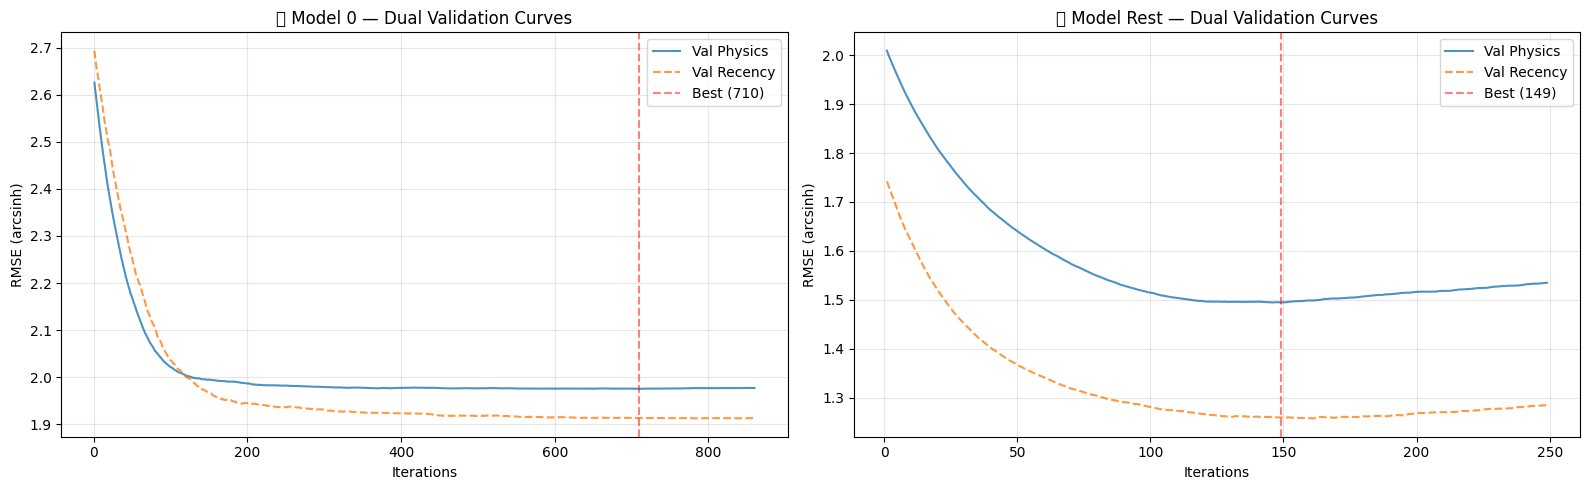


❄️ RMSE BY MARKET — PHYSICS VAL (Autumn/Winter 2024)
  🔷 M0 | Market 0 | Rows: 2928 | RMSE: 76.7574
  🟢 MR | Market 1 | Rows: 2928 | RMSE: 48.7263
  🟢 MR | Market 2 | Rows: 2928 | RMSE: 29.3104
  🟢 MR | Market 3 | Rows: 2928 | RMSE: 35.4003
  🟢 MR | Market 4 | Rows: 2928 | RMSE: 49.1279
  🟢 MR | Market 5 | Rows: 2928 | RMSE: 29.2465

🔥 RMSE BY MARKET — RECENCY VAL (Summer 2025)
  🔷 M0 | Market 0 | Rows: 2208 | RMSE: 86.5326
  🟢 MR | Market 1 | Rows: 2208 | RMSE: 27.1821
  🟢 MR | Market 2 | Rows: 2208 | RMSE: 25.9586
  🟢 MR | Market 3 | Rows: 2208 | RMSE: 26.8146
  🟢 MR | Market 4 | Rows: 2208 | RMSE: 28.2779
  🟢 MR | Market 5 | Rows: 2208 | RMSE: 20.5281

🔷 Top-10 Features — Model 0
    tightness_ratio: 56236
    demand_supply_balance: 43151
    renewable_ratio: 21819
    year: 17013
    supply_ratio: 12368
    wind_speed_10m: 11767
    wind_solar_interaction: 11457
    net_supply: 10599
    wind_solar_load_interaction: 9300
    wind_potential: 3852

🟢 Top-10 Features — Model Rest
   

In [46]:
# ── Learning Curves — Dual Validation ────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

vl_p_m0 = evals_result_m0["val_physics"]["rmse"]
vl_r_m0 = evals_result_m0["val_recency"]["rmse"]
axes[0].plot(range(1, len(vl_p_m0)+1), vl_p_m0, label='Val Physics', alpha=0.8, lw=1.5)
axes[0].plot(range(1, len(vl_r_m0)+1), vl_r_m0, label='Val Recency', alpha=0.8, lw=1.5, ls='--')
axes[0].axvline(x=model_m0.best_iteration, color='red', ls='--', alpha=0.5, label=f'Best ({model_m0.best_iteration})')
axes[0].set_xlabel('Iterations'); axes[0].set_ylabel('RMSE (arcsinh)')
axes[0].set_title('🔷 Model 0 — Dual Validation Curves')
axes[0].legend(); axes[0].grid(True, alpha=0.3)

vl_p_rest = evals_result_rest["val_physics"]["rmse"]
vl_r_rest = evals_result_rest["val_recency"]["rmse"]
axes[1].plot(range(1, len(vl_p_rest)+1), vl_p_rest, label='Val Physics', alpha=0.8, lw=1.5)
axes[1].plot(range(1, len(vl_r_rest)+1), vl_r_rest, label='Val Recency', alpha=0.8, lw=1.5, ls='--')
axes[1].axvline(x=model_rest.best_iteration, color='red', ls='--', alpha=0.5, label=f'Best ({model_rest.best_iteration})')
axes[1].set_xlabel('Iterations'); axes[1].set_ylabel('RMSE (arcsinh)')
axes[1].set_title('🟢 Model Rest — Dual Validation Curves')
axes[1].legend(); axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ── Per-Market RMSE — Physics Val ────────────────────────────────────────────
vp_res = val_physics_df[['delivery_start', 'market_id']].copy()
vp_res['actual'] = y_val_physics_real
vp_res['predicted'] = vp_combined

print('\n' + '=' * 65)
print('❄️ RMSE BY MARKET — PHYSICS VAL (Autumn/Winter 2024)')
print('=' * 65)
for mkt in sorted(vp_res['market_id'].unique()):
    d = vp_res[vp_res['market_id'] == mkt]
    tag = '🔷 M0' if mkt == 0 else '🟢 MR'
    print(f'  {tag} | Market {mkt} | Rows: {len(d):4d} | RMSE: {root_mean_squared_error(d["actual"], d["predicted"]):.4f}')
print('=' * 65)

# ── Per-Market RMSE — Recency Val ────────────────────────────────────────────
vr_res = val_recency_df[['delivery_start', 'market_id']].copy()
vr_res['actual'] = y_val_recency_real
vr_res['predicted'] = vr_combined

print('\n' + '=' * 65)
print('🔥 RMSE BY MARKET — RECENCY VAL (Summer 2025)')
print('=' * 65)
for mkt in sorted(vr_res['market_id'].unique()):
    d = vr_res[vr_res['market_id'] == mkt]
    tag = '🔷 M0' if mkt == 0 else '🟢 MR'
    print(f'  {tag} | Market {mkt} | Rows: {len(d):4d} | RMSE: {root_mean_squared_error(d["actual"], d["predicted"]):.4f}')
print('=' * 65)

# ── Top-10 Feature Importance ────────────────────────────────────────────────
print('\n' + '=' * 65)
print('🔷 Top-10 Features — Model 0')
print('=' * 65)
imp_m0 = pd.Series(model_m0.feature_importance('gain'), index=feat_cols_m0)
for f, v in imp_m0.nlargest(10).items():
    print(f'    {f}: {v:.0f}')

print('\n' + '=' * 65)
print('🟢 Top-10 Features — Model Rest')
print('=' * 65)
imp_rest = pd.Series(model_rest.feature_importance('gain'), index=feat_cols)
for f, v in imp_rest.nlargest(10).items():
    print(f'    {f}: {v:.0f}')

## Final Retrain & Test Predictions

In [47]:
# ══════════════════════════════════════════════════════════════════════════════
# GENERATE TEST PREDICTIONS (Time-Decay M0 + Static Rest)
# ══════════════════════════════════════════════════════════════════════════════

# Retrain on ALL observed data (train+val) for final submission
print("Retraining on full observed data for submission...")

mask_all_m0   = X_all["market_id"] == 0
mask_all_rest = X_all["market_id"] > 0

# Model 0 final — time-decay weights on FULL observed Market 0 data
X_all_m0 = X_all[mask_all_m0]
y_all_m0 = y_all[mask_all_m0.values]
weights_all_m0 = np.linspace(0.1, 1.0, len(X_all_m0))

ds_all_m0 = lgb.Dataset(
    X_all_m0[feat_cols_m0], y_all_m0,
    weight=weights_all_m0,
    categorical_feature="auto", free_raw_data=False,
)
model_m0_final = lgb.train(
    baseline_params_m0, ds_all_m0,
    num_boost_round=int(model_m0.best_iteration * 1.1),
)

# Model Rest final — use STATIC baseline params (no weights)
ds_all_rest = lgb.Dataset(
    X_all[mask_all_rest], y_all[mask_all_rest.values],
    categorical_feature=cat_idx if cat_idx else "auto", free_raw_data=False,
)
model_rest_final = lgb.train(
    baseline_params, ds_all_rest,
    num_boost_round=int(model_rest.best_iteration * 1.1),
)

# Predict on test set
mask_test_m0   = X_test["market_id"] == 0
mask_test_rest = X_test["market_id"] > 0

lgb_test_preds = np.empty(len(X_test))
lgb_test_preds[mask_test_m0.values]   = np.sinh(model_m0_final.predict(X_test[mask_test_m0][feat_cols_m0]))
lgb_test_preds[mask_test_rest.values] = np.sinh(model_rest_final.predict(X_test[mask_test_rest]))

print(f"✅ Test predictions generated: {len(lgb_test_preds):,} rows")
print(f"   Market 0 test rows:    {mask_test_m0.sum():,}  (time-decay weighted)")
print(f"   Markets 1-5 test rows: {mask_test_rest.sum():,}  (static baseline)")

Retraining on full observed data for submission...
✅ Test predictions generated: 13,098 rows
   Market 0 test rows:    2,183  (time-decay weighted)
   Markets 1-5 test rows: 10,915  (static baseline)


## Create Submission File

In [48]:
# ══════════════════════════════════════════════════════════════════════════════
# CREATE SUBMISSION FILE
# ══════════════════════════════════════════════════════════════════════════════

# Build prediction DataFrame keyed by id (our test_df is sorted by market/time,
# but sample_submission has a different id order — we must match it exactly)
pred_df = pd.DataFrame({
    "id": test_df["id"].values,
    "target": lgb_test_preds
})

# Merge onto sample_sub to guarantee identical id order
submission = sample_sub[["id"]].merge(pred_df, on="id", how="left")

# Sanity checks
assert len(submission) == len(sample_sub), f"Row mismatch: {len(submission)} vs {len(sample_sub)}"
assert submission["target"].isna().sum() == 0, f"Missing predictions for {submission['target'].isna().sum()} ids!"
assert (submission["id"] == sample_sub["id"]).all(), "ID order mismatch!"

# Save
submission_path = "../submissions/submission_split_timedecay.csv"
import os
os.makedirs("../submissions", exist_ok=True)
submission.to_csv(submission_path, index=False)

print(f"✅ Submission saved: {submission_path}")
print(f"   Rows: {len(submission):,}")
print(f"   ID order matches sample_submission: ✓")
print(f"   Target stats:")
print(f"     Mean:   {submission['target'].mean():.4f}")
print(f"     Std:    {submission['target'].std():.4f}")
print(f"     Min:    {submission['target'].min():.4f}")
print(f"     Max:    {submission['target'].max():.4f}")
print(f"     Median: {submission['target'].median():.4f}")

✅ Submission saved: ../submissions/submission_split_timedecay.csv
   Rows: 13,098
   ID order matches sample_submission: ✓
   Target stats:
     Mean:   24.3876
     Std:    20.8501
     Min:    -129.6524
     Max:    205.3956
     Median: 22.0639
